In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/552_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/267_crop16.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/50_crop12.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/405_crop11.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/598_crop9.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop2.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/435_crop14.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/373_crop8.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/175_crop13.png
/kaggle/input/major-final-kymograms-cropped/final kymograms cropped/functional/107_crop6.png
/kaggle/input/major-final-kymograms-cropped/final kymograms croppe

In [2]:
from pathlib import Path
import shutil, os
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

src_dir = Path("/kaggle/input/major-final-kymograms-cropped/final kymograms cropped")
dst_dir = Path("/kaggle/working/binary_split")

# Step 1: Map 3-class labels to binary
label_map = {
    'healthy': 'healthy',
    'functional': 'unhealthy',
    'organic': 'unhealthy'
}

# Step 2: Load and label all images
all_images = []
for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    if cls_dir.is_dir():
        mapped_label = label_map[cls]
        for img_path in cls_dir.glob("*.png"):
            all_images.append((img_path, mapped_label))

# Step 3: Split 15% test set
labels = [label for _, label in all_images]
trainval, test = train_test_split(all_images, test_size=0.15, stratify=labels, random_state=42)

# Step 4: Split 85% trainval into 70/15 split (82.35% train and 17.65% val of trainval)
trainval_labels = [label for _, label in trainval]
train, val = train_test_split(trainval, test_size=0.1765, stratify=trainval_labels, random_state=42)

# Step 5: Copy to new directory
def copy_images(data, split_name):
    for img_path, label in data:
        dest_dir = dst_dir / split_name / label
        dest_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, dest_dir / img_path.name)

copy_images(train, "train")
copy_images(val, "val")
copy_images(test, "test")

print(f" Data split complete:\n- Train: {len(train)}\n- Validation: {len(val)}\n- Test: {len(test)}")

# Step 6: Oversample to balance training set
train_dir = dst_dir / "train"
class_images = defaultdict(list)

for cls in os.listdir(train_dir):
    cls_path = train_dir / cls
    class_images[cls] = list(cls_path.glob("*.png"))

# Determine max class count
target_count = max(len(images) for images in class_images.values())

# Oversample
for cls, images in class_images.items():
    if len(images) < target_count:
        to_add = random.choices(images, k=target_count - len(images))
        for i, img_path in enumerate(to_add):
            new_name = img_path.stem + f"_dup{i}" + img_path.suffix
            shutil.copy(img_path, img_path.parent / new_name)

print(f"Training set balanced using random oversampling (~{target_count} per class)")

 Data split complete:
- Train: 6926
- Validation: 1485
- Test: 1485
Training set balanced using random oversampling (~4353 per class)


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define base path
base_path = Path("/kaggle/working/binary_split")

# Transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet-152
resnet = models.resnet152(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classifier
resnet.eval()

# Function to extract features
def extract_features(data_path, save_prefix):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc=f"Extracting from {save_prefix}"):
            output = resnet(inputs)
            features.append(output)
            labels.append(targets)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    np.save(f"/kaggle/working/{save_prefix}_features.npy", features)
    np.save(f"/kaggle/working/{save_prefix}_labels.npy", labels)

# Extract for train, val, and test
extract_features(base_path / "train", "train")
extract_features(base_path / "val", "val")
extract_features(base_path / "test", "test")

# Load features and labels
train_feats = np.load("/kaggle/working/train_features.npy")
train_labels = np.load("/kaggle/working/train_labels.npy")

val_feats = np.load("/kaggle/working/val_features.npy")
val_labels = np.load("/kaggle/working/val_labels.npy")

test_feats = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# Create DataLoaders
train_ds = TensorDataset(torch.tensor(train_feats, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(val_feats, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(test_feats, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Define binary classifier
class ConvNeXtV2Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtV2Classifier(input_dim=2048, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training settings
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Train and validate the model
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_convnextv2_binary.pth")

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {int(elapsed)}s - "
          f"Train Acc: {train_acc:.4f} - Train Loss: {train_loss:.4f} - "
          f"Val Acc: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

# Load best weights
model.load_state_dict(torch.load("best_model_convnextv2_binary.pth"))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 229MB/s] 
Extracting from test: 100%|██████████| 47/47 [05:34<00:00,  7.11s/it]


NameError: name 'TensorDataset' is not defined

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path
import torch.nn as nn
import torch.optim as optim
import time
import copy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Load features and labels
train_feats = np.load("/kaggle/working/train_features.npy")
train_labels = np.load("/kaggle/working/train_labels.npy")

val_feats = np.load("/kaggle/working/val_features.npy")
val_labels = np.load("/kaggle/working/val_labels.npy")

test_feats = np.load("/kaggle/working/test_features.npy")
test_labels = np.load("/kaggle/working/test_labels.npy")

# Create DataLoaders
train_ds = TensorDataset(torch.tensor(train_feats, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
val_ds = TensorDataset(torch.tensor(val_feats, dtype=torch.float32), torch.tensor(val_labels, dtype=torch.long))
test_ds = TensorDataset(torch.tensor(test_feats, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Define binary classifier
class ConvNeXtV2Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, 1024),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtV2Classifier(input_dim=2048, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

# Training settings
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

# Train and validate the model
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = time.time()

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model_convnextv2_binary.pth")

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {int(elapsed)}s - "
          f"Train Acc: {train_acc:.4f} - Train Loss: {train_loss:.4f} - "
          f"Val Acc: {val_acc:.4f} - Val Loss: {val_loss:.4f}")

# Load best weights
model.load_state_dict(torch.load("best_model_convnextv2_binary.pth"))



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 - 1s - Train Acc: 0.7203 - Train Loss: 0.5316 - Val Acc: 0.7973 - Val Loss: 0.4355
Epoch 2/30 - 0s - Train Acc: 0.8617 - Train Loss: 0.3188 - Val Acc: 0.9084 - Val Loss: 0.2614
Epoch 3/30 - 0s - Train Acc: 0.9435 - Train Loss: 0.1520 - Val Acc: 0.9172 - Val Loss: 0.2013
Epoch 4/30 - 0s - Train Acc: 0.9707 - Train Loss: 0.0835 - Val Acc: 0.9636 - Val Loss: 0.1106
Epoch 5/30 - 0s - Train Acc: 0.9801 - Train Loss: 0.0582 - Val Acc: 0.9737 - Val Loss: 0.0810
Epoch 6/30 - 0s - Train Acc: 0.9900 - Train Loss: 0.0322 - Val Acc: 0.9764 - Val Loss: 0.0616
Epoch 7/30 - 0s - Train Acc: 0.9894 - Train Loss: 0.0311 - Val Acc: 0.9791 - Val Loss: 0.0741
Epoch 8/30 - 0s - Train Acc: 0.9926 - Train Loss: 0.0199 - Val Acc: 0.9872 - Val Loss: 0.0299
Epoch 9/30 - 0s - Train Acc: 0.9943 - Train Loss: 0.0181 - Val Acc: 0.9650 - Val Loss: 0.0943
Epoch 10/30 - 0s - Train Acc: 0.9929 - Train Loss: 0.0201 - Val Acc: 0.9832 - Val Loss: 0.0475
Epoch 11/30 - 0s - Train Acc: 0.9961 - Train Loss: 0.0142 -

/tmp/ipykernel_31/659174408.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_convnextv2_binary.pth"))


<All keys matched successfully>


VALIDATION PERFORMANCE
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.79
Precision (%)          99.89
Recall (%)             99.68
Sensitivity (%)        99.68
Specificity (%)        99.82
----------------------------------------
Unhealthy
F1 Score (%)           99.64
Precision (%)          99.46
Recall (%)             99.82
Sensitivity (%)        99.82
Specificity (%)        99.68
----------------------------------------
Overall Accuracy (%)   99.73
AUC Score (%)          99.99


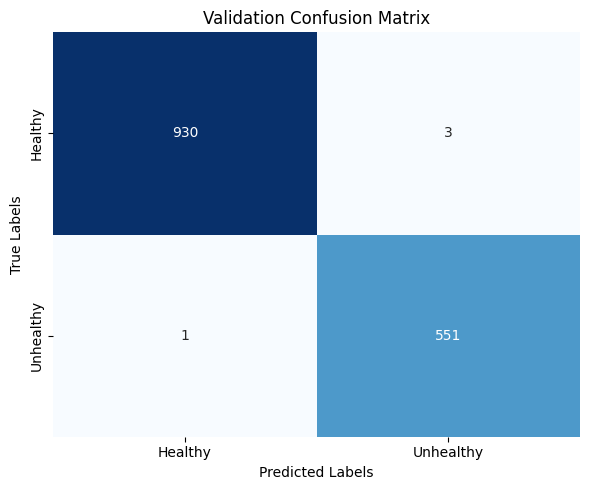

In [5]:
# ------------------------ VALIDATION REPORT ------------------------
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()
val_y_true, val_y_pred, val_y_probs = [], [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        val_y_true.extend(y.cpu().numpy())
        val_y_pred.extend(preds.cpu().numpy())
        val_y_probs.extend(probs.cpu().numpy())

val_y_true = np.array(val_y_true)
val_y_pred = np.array(val_y_pred)
val_y_probs = np.array(val_y_probs)

class_names = ['Healthy', 'Unhealthy']
n_classes = len(class_names)
val_auc = roc_auc_score(val_y_true, val_y_probs[:, 1]) * 100
val_report = classification_report(val_y_true, val_y_pred, target_names=class_names, output_dict=True)
val_conf_matrix = confusion_matrix(val_y_true, val_y_pred)

val_sensitivity, val_specificity = [], []

for i in range(n_classes):
    TP = val_conf_matrix[i, i]
    FN = val_conf_matrix[i].sum() - TP
    FP = val_conf_matrix[:, i].sum() - TP
    TN = val_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    val_sensitivity.append(sensitivity)
    val_specificity.append(specificity)

val_acc = accuracy_score(val_y_true, val_y_pred) * 100

print("\nVALIDATION PERFORMANCE")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)
for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{val_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{val_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{val_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{val_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{val_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{val_acc:>8.2f}")
print(f"{'AUC Score (%)':<20}{val_auc:>8.2f}")

plt.figure(figsize=(6, 5))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



TEST PERFORMANCE
Metrics             Value
----------------------------------------
Healthy
F1 Score (%)           99.62
Precision (%)          99.89
Recall (%)             99.36
Sensitivity (%)        99.36
Specificity (%)        99.82
----------------------------------------
Unhealthy
F1 Score (%)           99.37
Precision (%)          98.92
Recall (%)             99.82
Sensitivity (%)        99.82
Specificity (%)        99.36
----------------------------------------
Overall Accuracy (%)   99.53
AUC Score (%)          99.97


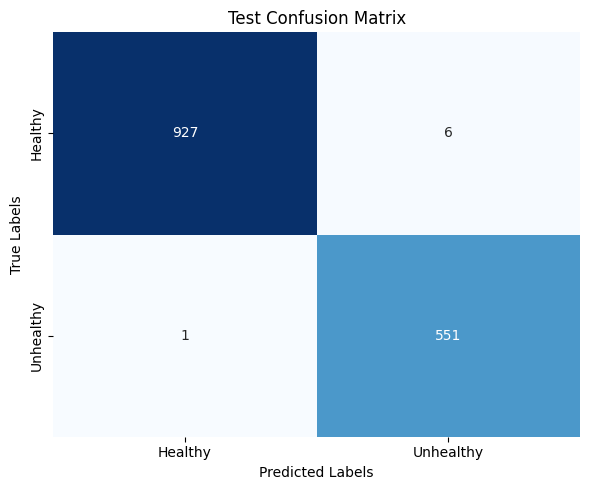

In [6]:
# ------------------------ TEST REPORT ------------------------
test_y_true, test_y_pred, test_y_probs = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_y_true.extend(y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs.cpu().numpy())

test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)
test_y_probs = np.array(test_y_probs)

test_auc = roc_auc_score(test_y_true, test_y_probs[:, 1]) * 100
test_report = classification_report(test_y_true, test_y_pred, target_names=class_names, output_dict=True)
test_conf_matrix = confusion_matrix(test_y_true, test_y_pred)

test_sensitivity, test_specificity = [], []

for i in range(n_classes):
    TP = test_conf_matrix[i, i]
    FN = test_conf_matrix[i].sum() - TP
    FP = test_conf_matrix[:, i].sum() - TP
    TN = test_conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) * 100 if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) * 100 if (TN + FP) > 0 else 0

    test_sensitivity.append(sensitivity)
    test_specificity.append(specificity)

test_acc = accuracy_score(test_y_true, test_y_pred) * 100

print("\nTEST PERFORMANCE")
print(f"{'Metrics':<20}{'Value'}")
print("-" * 40)
for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'F1 Score (%)':<20}{test_report[cls]['f1-score']*100:>8.2f}")
    print(f"{'Precision (%)':<20}{test_report[cls]['precision']*100:>8.2f}")
    print(f"{'Recall (%)':<20}{test_report[cls]['recall']*100:>8.2f}")
    print(f"{'Sensitivity (%)':<20}{test_sensitivity[i]:>8.2f}")
    print(f"{'Specificity (%)':<20}{test_specificity[i]:>8.2f}")
    print("-" * 40)

print(f"{'Overall Accuracy (%)':<20}{test_acc:>8.2f}")
print(f"{'AUC Score (%)':<20}{test_auc:>8.2f}")

plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


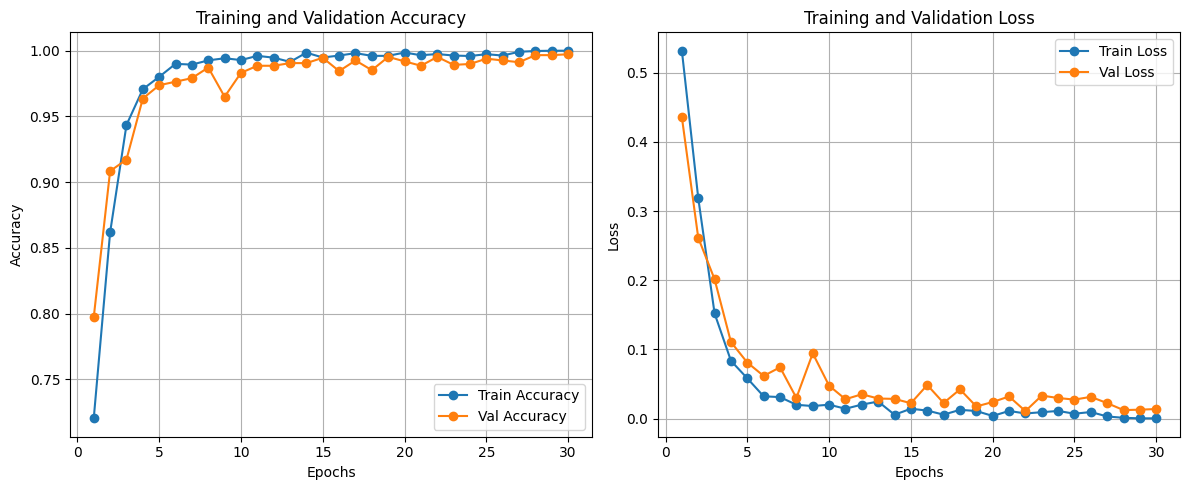

In [7]:
# Plot training & validation accuracy/loss
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_acc"], label="Train Accuracy", marker='o')
plt.plot(epochs_range, history["val_acc"], label="Val Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs_range, history["val_loss"], label="Val Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import roc_curve, auc
import json

# Step: Evaluate on test set and collect predictions
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device)
        outputs = model(features)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probs for class 1
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute ROC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Save FPR, TPR, AUC
roc_data = {
    "model": "ConvNeXtV2-Binary",
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist(),
    "auc": roc_auc
}

with open("roc_data_convnextv2_binary.json", "w") as f:
    json.dump(roc_data, f)

print("✅ ROC data saved to roc_data_convnextv2_binary.json")


✅ ROC data saved to roc_data_convnextv2_binary.json


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import torch

# Put model in evaluation mode
model.eval()

# Collect predictions and true labels
test_y_true = []
test_y_pred = []
test_y_probs = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        test_y_true.extend(y.cpu().numpy())
        test_y_pred.extend(preds.cpu().numpy())
        test_y_probs.extend(probs[:, 1].cpu().numpy())  # probability of positive class

# Convert to numpy arrays
test_y_true = np.array(test_y_true)
test_y_pred = np.array(test_y_pred)
test_y_probs = np.array(test_y_probs)

# Compute metrics
test_acc = accuracy_score(test_y_true, test_y_pred)
test_auc = roc_auc_score(test_y_true, test_y_probs)
fpr, tpr, _ = roc_curve(test_y_true, test_y_probs)

# Save metrics
final_metrics = {
    "test_accuracy": test_acc,
    "test_auc": test_auc,
    "fpr": fpr.tolist(),
    "tpr": tpr.tolist()
}

# Save to file (optional)
import json
with open("final_test_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_test.png")
plt.show()
